# Calibrating PKPD Model to AL TES Data from [Bassat et al., 2009](https://pubmed.ncbi.nlm.nih.gov/19936217/) and [Baraka et al., 2014](https://journals.asm.org/doi/10.1128/aac.03647-14)

## **Parameters**: 50k patients, 50 values of pmax_lum with EC50_lum, pmax_art and EC50_art at default values

## **Drug:** AL

### **Gene locus and Allele:** pfmdr1 N86

**Number of patients in arm:** 56

**Number of patients cured:** 49

**Efficacy:** 0.875 or 87.5%


### **Gene locus and Allele:** pfmdr1 86Y
**Number of patients in arm:** 35

**Number of patients cured:** 35

**Efficacy:** 1 or 100%


### **Gene locus and Allele:** pfcrt K76
**Number of patients in arm:** 27

**Number of patients cured:** 25

**Efficacy:** 0.9259 or 92.59%


### **Gene locus and Allele:** pfcrt 76T
**Number of patients in arm:** 62

**Number of patients cured:** 57

**Efficacy:** 0.9194 or 91.94%


<br>

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from timeit import default_timer as timer
from matplotlib.ticker import MaxNLocator
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count

### Testing efficacy of ART at default with pmax_lum = 0

In [2]:
command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_lum", "0",
        "-o", "1"
    ]

output_pmax_lum = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

# Process the output
lines_pmax_lum = output_pmax_lum.stdout.splitlines()
df_pmax_lum = pd.DataFrame([line.split(',') for line in lines_pmax_lum], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
# Clean the DataFrame
df_pmax_lum = df_pmax_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

failed_treatment_count = df_pmax_lum[(df_pmax_lum['PARASITEDENSITY'] >= 10)].shape[0]
total_patients = df_pmax_lum['PID'].nunique()
efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

print(f"Failed treatment count: {failed_treatment_count}")
print(f"Efficacy: {efficacy:.2f}%")

Failed treatment count: 0
Efficacy: 100.00%


<br>

### Calculating efficacy with 50 different values of pmax_lum and with pmax_art at default
#### pmax_lum Range: 0.5 to 0.9995 
#### Number of Patients: 5000

In [3]:
# Define the range for pmax_lum
min_pmax = 0.5
max_pmax = 0.9995

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 50)  

# Initialize a grid to store the clearance rates
efficacy = np.zeros(len(pmax_values))

In [ ]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_lum", str(pmax),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_lum = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_lum = output_pmax_lum.stdout.splitlines()
        df_pmax_lum = pd.DataFrame([line.split(',') for line in lines_pmax_lum], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_lum = df_pmax_lum.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_lum[(df_pmax_lum['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_lum['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, eff in results:
    efficacy[idx] = eff

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_lum': pmax_values,
    'efficacy': efficacy
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_lum_50.vals_5k.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_lum_50.vals_5k.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [15:50<00:00, 19.00s/it]   

DataFrame saved as pickle and CSV files successfully.


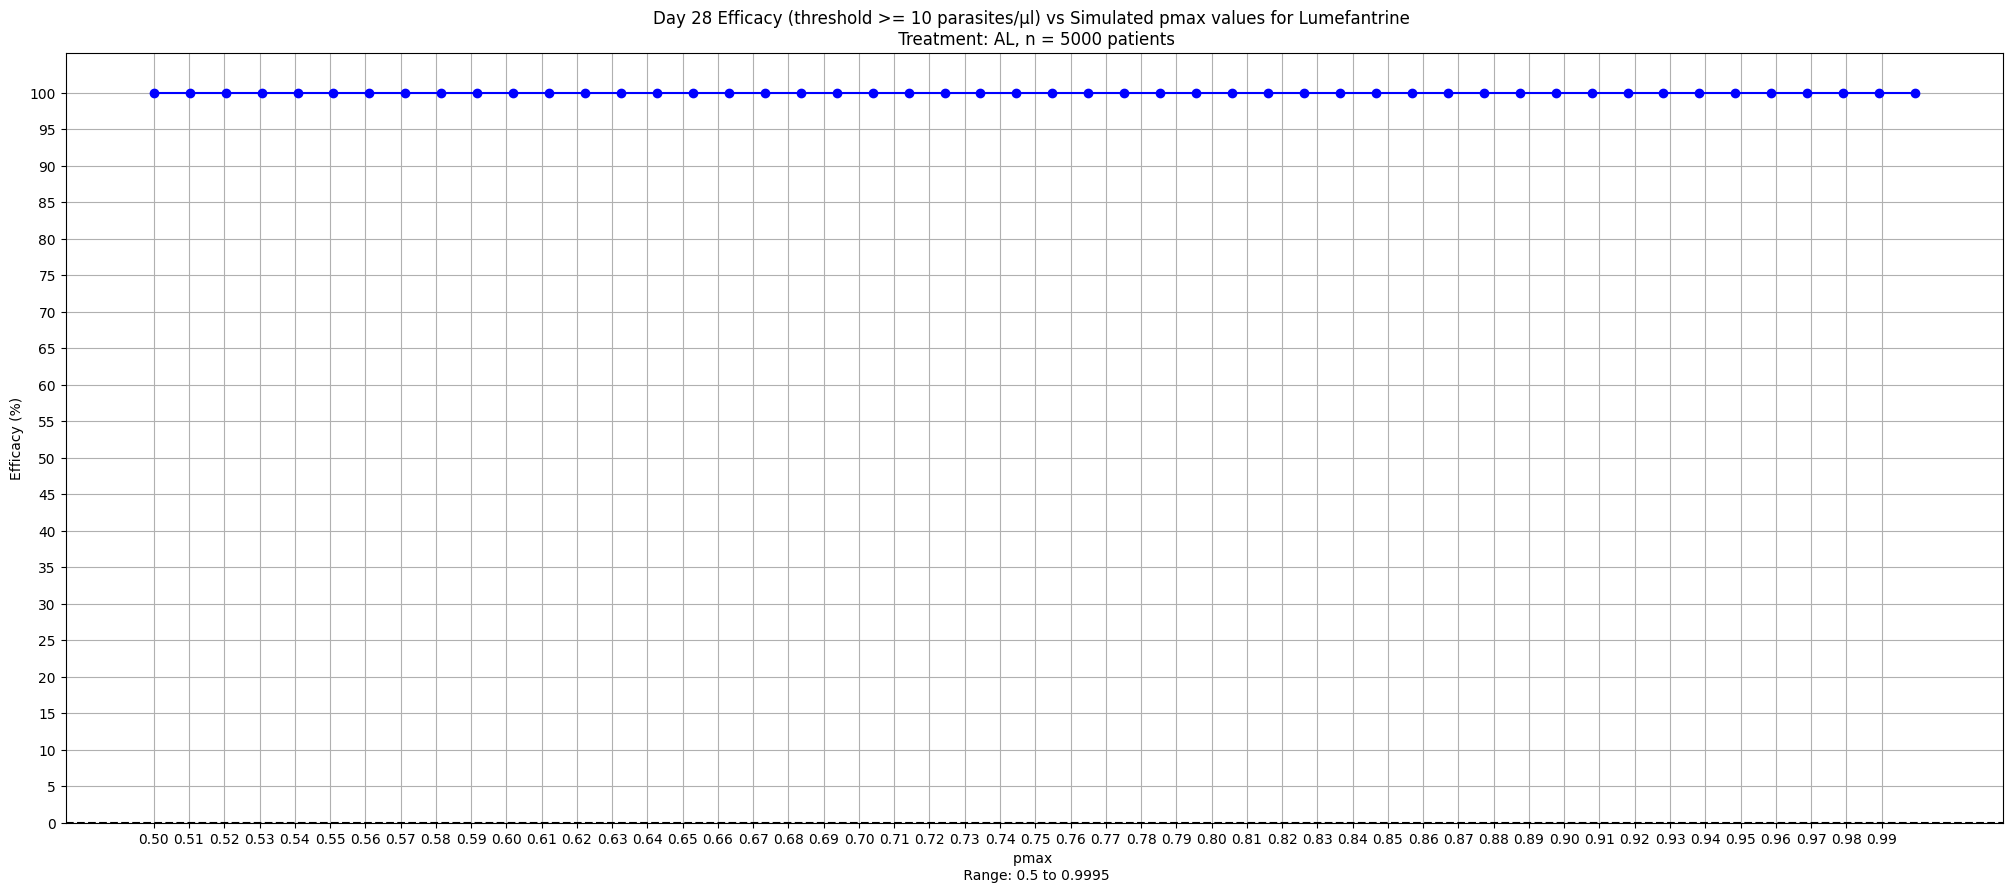

In [15]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.5 to 0.9995')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Lumefantrine \n Treatment: AL, n = 5000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.01))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.show()

<br>

In [18]:
# Define the range for pmax_art
min_pmax = 0.5
max_pmax = 0.9

# Define pmax_art values
pmax_values = np.linspace(min_pmax, max_pmax, 50)  

# Initialize a grid to store the clearance rates
efficacy = np.zeros(len(pmax_values))

In [37]:
pmax_values

array([0.5       , 0.50816327, 0.51632653, 0.5244898 , 0.53265306,
       0.54081633, 0.54897959, 0.55714286, 0.56530612, 0.57346939,
       0.58163265, 0.58979592, 0.59795918, 0.60612245, 0.61428571,
       0.62244898, 0.63061224, 0.63877551, 0.64693878, 0.65510204,
       0.66326531, 0.67142857, 0.67959184, 0.6877551 , 0.69591837,
       0.70408163, 0.7122449 , 0.72040816, 0.72857143, 0.73673469,
       0.74489796, 0.75306122, 0.76122449, 0.76938776, 0.77755102,
       0.78571429, 0.79387755, 0.80204082, 0.81020408, 0.81836735,
       0.82653061, 0.83469388, 0.84285714, 0.85102041, 0.85918367,
       0.86734694, 0.8755102 , 0.88367347, 0.89183673, 0.9       ])

In [38]:
# Function to run a single simulation for a given pmax_art value
def run_simulation(idx, pmax):
    command_pmax_art_adj = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "100",
        "--pmax_art", str(pmax),
        "--pmax_lum", "0",
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_pmax_art = subprocess.run(command_pmax_art_adj, capture_output=True, text=True, check=True)

        # Process the output
        lines_pmax_art = output_pmax_art.stdout.splitlines()
        df_pmax_art = pd.DataFrame([line.split(',') for line in lines_pmax_art], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_pmax_art = df_pmax_art.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_pmax_art[(df_pmax_art['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_pmax_art['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) 

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {pmax}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, pmax_values[i]) for i in range(len(pmax_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the efficacy array with the results
for idx, eff in results:
    efficacy[idx] = eff

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'pmax_art': pmax_values,
    'efficacy': efficacy
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_pmax_art_50.vals_pmax_lum_0_5k.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_pmax_art_50.vals_pmax_lum_0_5k.csv", index=False)


print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 50/50 [00:12<00:00,  4.09it/s]

DataFrame saved as pickle and CSV files successfully.


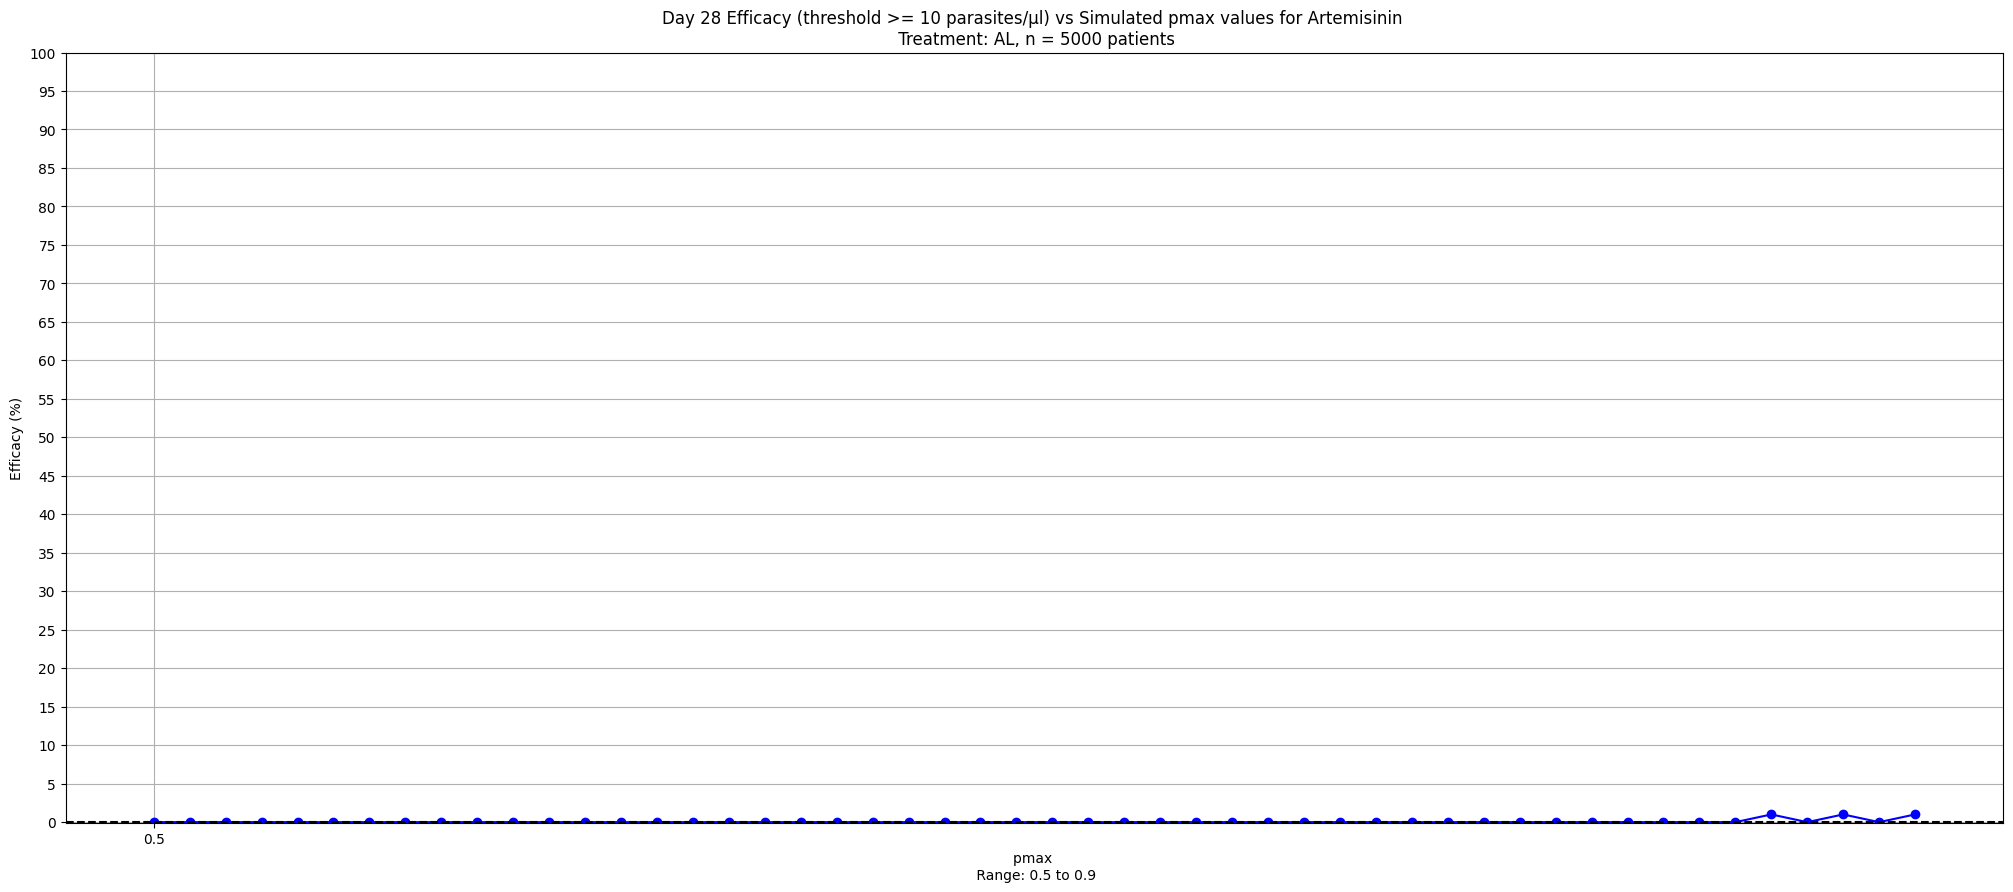

In [39]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(pmax_values, efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('pmax \n Range: 0.5 to 0.9')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Simulated pmax values for Artemisinin \n Treatment: AL, n = 5000 patients")
plt.grid(True)
plt.xticks(np.arange(min(pmax_values), max(pmax_values), 0.5))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig('pkpd_AL_pmax_art_efficacy_5k.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
efficacy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.])

In [41]:
df_pmax_art

NameError: name 'df_pmax_art' is not defined

In [32]:
total_patients

5000

In [33]:
failed_treatment_count

0

In [35]:
100 - ((failed_treatment_count / total_patients) * 100)

100.0

In [36]:
(100 - ((failed_treatment_count / total_patients) * 100)) 

100.0